# Part 1 - Data Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

Importing the Dataset

In [2]:
df = pd.read_csv('GOOGL.csv', index_col = 0, usecols = [0,1], parse_dates = True) #index_col = 0 grabs the first column and sets it to the index, parse_dates = True automatically makes pandas convert the index into a date time object. 
#usecols allows us to grab just the columns we want, in this case we just care about the open price of the stock
df

,Open
Date,
2009-05-22,198.528534
2009-05-26,196.171173
2009-05-27,203.023026
2009-05-28,204.544540
2009-05-29,206.261261
...,...
2018-08-23,1219.880005
2018-08-24,1226.000000
2018-08-27,1244.140015


In [3]:
df = df.dropna() #dropping any null values
len(df) #length is the same, so there were no null values

2335

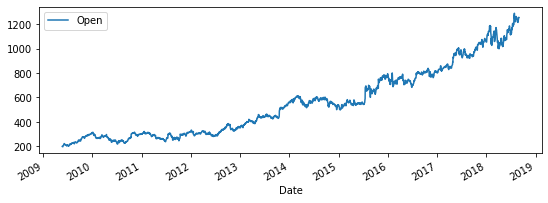

In [4]:
df.plot(figsize=(9,3)) #Looks like Google has been killing it over the past decade

In [5]:
y = df['Open'].values #setting the Open column as our Label

In [6]:
#so every new stamp of data is from a weekday. 1 year has 261 financial days
test_size = 261 #going to the last year

train_set = y[:-test_size] #using all the years before May 2018
test_set = y[-test_size:]
print(len(train_set))
print(len(test_set))

2074
261


Normalizing Data

In [7]:
#We need to normalize the data between -1 and 1, and we normalize the data because RNN's typically train better due to the way weights and biases update after normalization
#In this dataset, we can see an order of magnitude change going from ~200 to ~1300. When we have a very large change in data magnitude, it's a better idea to normalize the data
scaler = MinMaxScaler(feature_range=(-1,1)) #so here we're scaling the values down from -1 to 1

train_norm = scaler.fit_transform(train_set.reshape(-1,1))  #now we're fitting the scaling to the train_set then we're actually transforming our data to be between -1 and 1

print(train_norm[0:10]) #notice how all the values are between -1 and 1 now, with row 2 being the lowest google stock has been in the last decade
print(train_norm.shape)

[[-0.99417446]
 [-1.        ]
 [-0.9830676 ]
 [-0.97930762]
 [-0.97506523]
 [-0.96687734]
 [-0.95757627]
 [-0.95788548]
 [-0.94638281]
 [-0.93429888]]
(2074, 1)


Creating a Data Structure with 66 Timesteps and 1 Output

In [8]:
#so our RNN will look at the 261 stock prices before time T, and use that to predict our t+1 stock price
#261 weekdays in 1 year

X_train = [] #just creating the object for the X train
y_train = [] #just creating the object for the y train

#below we're starting with Index 66 (since we need the 66 days before i), then ending on Index 2269, which is the last row from our train set
for i in range(261, 2074):
  X_train.append(train_norm[i-261:i, 0])
  y_train.append(train_norm[i,0])
  #X_train is using data from 0 to 65, whereas y_Train is the prediction of data 66

X_train, y_train = np.array(X_train), np.array(y_train) #now we have our datastructure in the right format
X_train.shape #66 columns for data from each day

(1813, 261)

Reshaping

In [9]:
#we're adding another dimension in our numpy array for X_train, so we can add more indicators but also to make the shape compatible with the input format of the RNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #our current X_train is 2 dimensions of X_train.shape[0] = 2203 rows and X_train.shape[1] = 2 columns, but we're adding a 3rd dimension, which is our number of indicators/predictors, which is 1. The parameters are (batch size = X_train.shape[0] (rows, which is number of stock prices), time step = X_train.shape[1] (columns), and input_dim, the predictor)
X_train.shape

(1813, 261, 1)

# Part 2 - Building the RNN

In [10]:
def RNN():
  #Initializing
  regressor = tf.keras.models.Sequential() #regression is for predicting a continuous value, whereas classifier is for predicting a classification 

  #Adding the hidden layers
  regressor.add(tf.keras.layers.LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1],1))) #making our regressor use an LSTM layer. We had 50 neurons (or LSTM layers), our return_sequences is true because we're making a stacked LSTM layer so adding another one means this parameters must be true, and the input shape is our time step and predictor
  regressor.add(tf.keras.layers.Dropout(0.4))

  regressor.add(tf.keras.layers.LSTM(units = 64, return_sequences = True)) #don't need to specify our input shape anymore, only the first LSTM layer needs that
  regressor.add(tf.keras.layers.Dropout(0.4))

  regressor.add(tf.keras.layers.LSTM(units = 64, return_sequences = True)) #don't need to specify our input shape anymore, only the first LSTM layer needs that
  regressor.add(tf.keras.layers.Dropout(0.4))

  regressor.add(tf.keras.layers.LSTM(units = 64, return_sequences = False)) #return_sequences is false since we're not stacking anymore layers and just getting the output after
  regressor.add(tf.keras.layers.Dropout(0.4))

  #Adding the output layer
  regressor.add(tf.keras.layers.Dense(units = 1)) #output of 1 as our prediction

  #Compiling the ANN
  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error') #RMSProp is usually a good choice for RNN, but Adam is always a safe choice, and our loss is MSE since we're doing a regression problem instead of classification
  #adam optimizer is usually one of the best ones for performing stochastic gradient descent  
  return regressor

In [11]:
regressor = RNN()

Fitting the RNN to the Training Set

In [12]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("GoogleStockPredictor_v2.h5", monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)

In [ ]:
regressor.fit(X_train, y_train, epochs=100, batch_size = 32, callbacks=[checkpoint])

In [14]:
from keras.models import load_model
model = load_model('GoogleStockPredictor_v2.h5')

# Part 3 - Making the Predictions and Visualizing the Results

Getting the Predicted Stock Price of 2017

In [15]:
total = df['Open']
total.shape

(2335,)

In [16]:
inputs = total[len(total) - len(test_set) - 261:].values #here we're taking the 66 days before the first test set day. To do this, we just subtract the length of the total data set by the length of the test data set, then subtract 66 to get the 66 days prior
inputs.shape

(522,)

In [17]:
inputs = inputs.reshape(-1,1)
inputs.shape

(522, 1)

In [18]:
inputs = scaler.transform(inputs) #we didn't use fit_transform because our scaler object was already fitted to our training set above. However, the scaling applied to our input must be the same scaling applied to the training set still, which is why we transform it still
inputs.shape

(522, 1)

In [ ]:
X_test = [] #just creating the object for the X train

#below we're starting with Index 66 (since we need the 66 days before i), then ending on Index 132, which is the last piece of our data set
for i in range(261, 522):
  X_test.append(inputs[i-261:i, 0])
#X_train is using data from 0 to 65

X_test = np.array(X_test) #now we have our datastructure in the right format

In [20]:
#we're adding another dimension in our numpy array for X_test, so we can add more indicators but also to make the shape compatible with the input format of the RNN
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) #our current X_test is 2 dimensions of X_test.shape[0] = 66 rows and X_ttest.shape[1] = 66 columns, but we're adding a 3rd dimension, which is our number of indicators/predictors, which is 1 (the output). The parameters are (batch size = X_train.shape[0] (rows, which is number of stock prices), time step = X_train.shape[1] (columns), and input_dim, the predictor)
X_test.shape

(261, 261, 1)

In [21]:
predicted_stock_price = regressor.predict(X_test) #now predicting the scaled stock price between 0 and 1
predicted_stock_price.shape

(261, 1)

In [ ]:
predicted_stock_price = scaler.inverse_transform(predicted_stock_price) #reversing the scaling now so we can get the values in the real original monetary values

Visualization

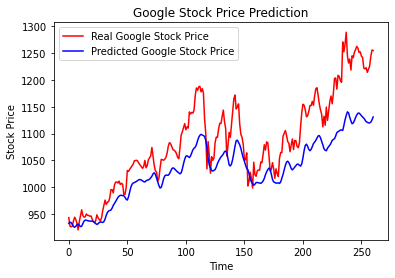

In [23]:
plt.plot(test_set, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()